# Sobre o projeto

Conforme a descrição e README deste projeto, o objetivo é realizar uma exploração e modelagem de um modelo de Machine Learning conforme o material visto durante as aulas.

Escolhemos construir um **modelo de ** para prever a **geração** de energia de usinas térmicas  com base em suas condições de operações, como temperatura e pressão.

# Coleta dos dados e setup

## Importações

Centralização das importações que serão utilizadas ao longo do arquivo em diversas etapas

In [36]:
# Análise
import pandas as pd
import numpy as np

# Visualização
import seaborn as sns
import matplotlib.pyplot as plt

# Pré-processamento
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import train_test_split

# Machine Learning - Modelos e métricas
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from xgboost import XGBRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, mean_squared_error, r2_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV

## Importanto os dados

In [2]:
energy_train_data = pd.read_csv('Training_set_ccpp.csv')
energy_test_data = pd.read_csv('Testing_set_ccpp.csv')

In [3]:
energy_train_data.head()

,AT,EV,AP,RH,PE
0,29.95,73.42,1011.44,66.32,432.81
1,5.76,40.07,1013.22,62.99,494.67
2,29.44,64.33,1011.40,61.78,442.32
3,32.83,74.33,1011.44,50.42,427.36
4,16.86,39.63,1004.47,83.50,466.68


In [4]:
energy_test_data.head()

,AT,EV,AP,RH
0,19.64,48.06,1014.81,74.96
1,28.26,69.23,1013.01,42.10
2,27.98,67.17,1007.32,75.29
3,28.64,69.23,1013.11,37.13
4,9.34,38.08,1019.56,67.74


# Desenvolvimento

## EDA (Exploratory Data Analysis) dos dados

Aqui os dados serão analisados de forma geral, ajudando a compreender melhor seus padrões e comportamento, além de quais tratamentos e/ou criações de novas colunas podem aparecer na etapa de pré-processamento.

### Sobre

Como implícito no nome dos dois datasets, eles foram divididos em dataset de treino (energy_train_dataset) e dataset de test(energy_test_dataset). Ao analisarmos ambos os datasets observamos que possuímos as seguintes colunas a seguir:

In [5]:
energy_train_data.columns

Index(['AT', 'EV', 'AP', 'RH', 'PE'], dtype='object')

In [6]:
energy_test_data.columns

Index(['AT', 'EV', 'AP', 'RH'], dtype='object')

Consultando o dicionário de dados chegamos temos a explicação do que se trata as inicias de cada variável bem como a unidade em que estão sendo medidas, segundo a tabela a seguir:

| Coluna                 | Unidade                       | Descrição                                                                                 |
|------------------------|-------------------------------|-------------------------------------------------------------------------------------------|
| `AT`        | *°C*       | Temperatura ambiente                |
| `EV`     | *Hg*         | Vácuo de Exaustão  |
| `AP`          | *mbar*                      | Pressão ambiente                             |
| `RH`       | *%*                      | Humidade Relativa                   |                               |
| `PE`       | *MW*                      | Geração de energia elétrica                    |                               |

Conforme explicitamente recomendado pela fonte de dados iremos utilizar apenas o dataset de treino (train) para realizar o treino do modelo. Logo todas as análises e tratamento a seguir serão realizadas apenas neste dataset.

### Informações gerais do dataset

In [7]:
print(f'{energy_train_data.shape[0]} linhas e {energy_train_data.shape[1]} colunas.')

6410 linhas e 5 colunas.


Todos os dados são do tipo float64

In [8]:
energy_train_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6410 entries, 0 to 6409
Data columns (total 5 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   AT      6410 non-null   float64
 1   EV      6410 non-null   float64
 2   AP      6410 non-null   float64
 3   RH      6410 non-null   float64
 4   PE      6410 non-null   float64
dtypes: float64(5)
memory usage: 250.5 KB


Também não temos valores nulos no dataset

In [9]:
energy_train_data.isna().sum()

AT    0
EV    0
AP    0
RH    0
PE    0
dtype: int64

Temos uma pequena quantidade de dados duplicados, logo iremos removê-los para que não influenciem no nosso modelo.

In [10]:
len(energy_train_data[energy_train_data.duplicated()])

14

In [11]:
energy_train_data = energy_train_data.drop_duplicates()
energy_train_data

,AT,EV,AP,RH,PE
0,29.95,73.42,1011.44,66.32,432.81
1,5.76,40.07,1013.22,62.99,494.67
2,29.44,64.33,1011.40,61.78,442.32
3,32.83,74.33,1011.44,50.42,427.36
4,16.86,39.63,1004.47,83.50,466.68
...,...,...,...,...,...
6405,23.39,61.87,1010.35,48.91,444.03
6406,11.63,40.55,1022.89,87.12,474.67
6407,27.79,69.23,1012.86,45.71,435.06
6408,12.26,41.50,1014.87,89.41,471.13


In [12]:
energy_train_data.describe()

,AT,EV,AP,RH,PE
count,6396.000000,6396.000000,6396.000000,6396.000000,6396.000000
mean,19.655775,54.289472,1013.218404,73.318247,454.350688
std,7.428144,12.675436,5.933810,14.684819,17.040970
min,1.810000,25.360000,992.890000,26.300000,420.260000
25%,13.580000,41.760000,1009.060000,63.340000,439.830000
50%,20.420000,52.065000,1012.945000,74.955000,451.440000
75%,25.720000,66.517500,1017.220000,84.902500,468.240000
max,35.560000,81.560000,1033.300000,100.160000,495.760000


#### Análises gráficas

##### Histogramas

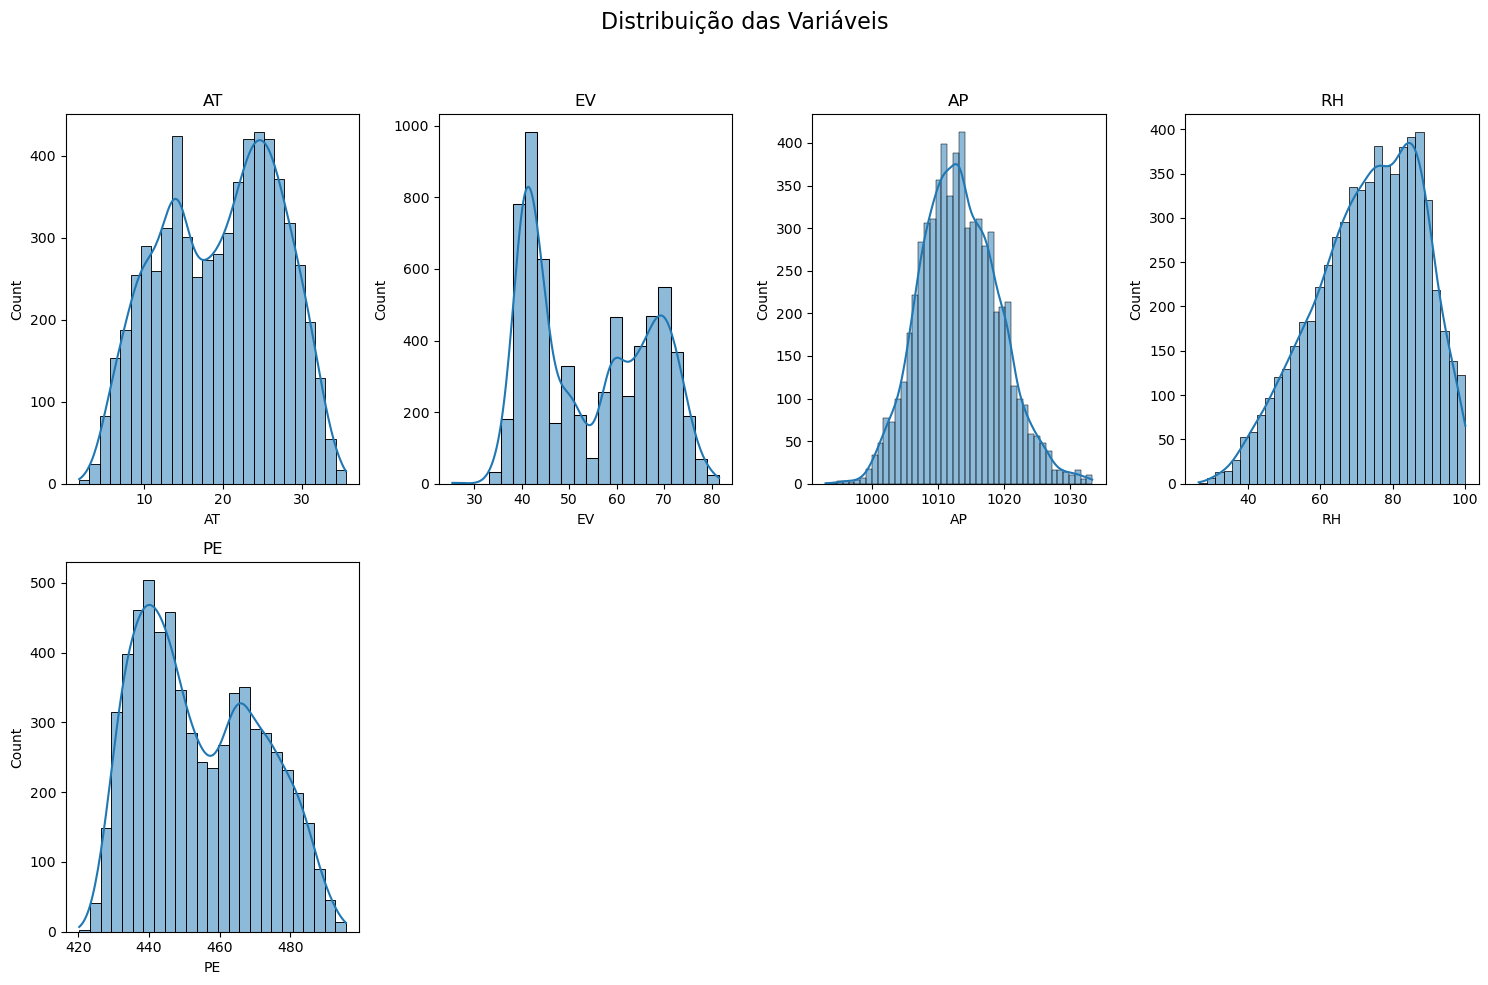

In [13]:
import math

num_vars = len(energy_train_data.columns)

cols = 4
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
fig.suptitle('Distribuição das Variáveis', fontsize=16)

for i, col in enumerate(energy_train_data.columns):
    ax = axes[i // cols, i % cols]
    sns.histplot(energy_train_data[col], kde=True, ax=ax)
    ax.set_title(col)

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

Como nossos dados são contínuos, a correlação mais apropriada é a de *Pearson*

Avaliando o heatmap abaixo, percebemos que há uma fortíssima correlação negativa entre PE e AT (-0.948) e também entre PE e EV (-0.869), indicando que quanto menor a temperatura ambiente e quanto mentor o vácuo de exaustão maior será a geração de energia.

Mediante estas análises, podemos levar em consideração que estas são as variáveis mais significativas para o treino do nosso modelo a fim de obter a predição da geração de energia nesta usina.

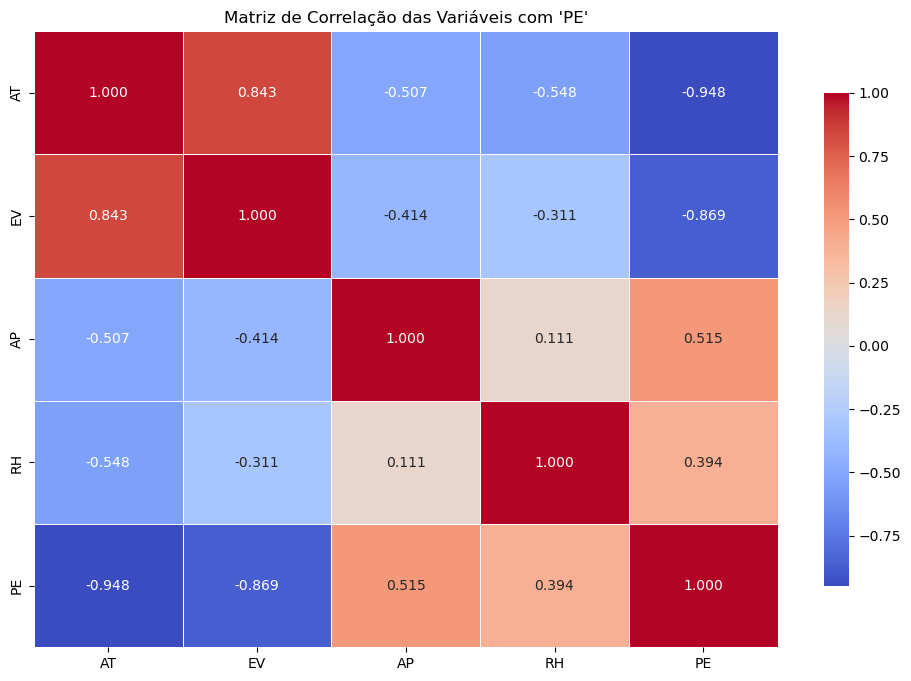

In [14]:
energy_generation_corr_df = energy_train_data
correlation_matrix = energy_generation_corr_df.corr(method='pearson')

plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".3f", linewidths=0.5, cbar_kws={"shrink": 0.8})
plt.title("Matriz de Correlação das Variáveis com 'PE'")
plt.show()

In [15]:
energy_train_data_bp_df = energy_generation_corr_df
most_pos_correlation = energy_train_data_bp_df.corrwith(energy_generation_corr_df['PE']).nlargest(3).index
most_neg_correlation = energy_train_data_bp_df.corrwith(energy_generation_corr_df['PE']).nsmallest(3).index

# apenas variáveis que tiveram uma correlação mais interessante com 'quality'
best_corr_columns = np.unique(most_pos_correlation.append(most_neg_correlation))
best_corr_columns

array(['AP', 'AT', 'EV', 'PE', 'RH'], dtype=object)

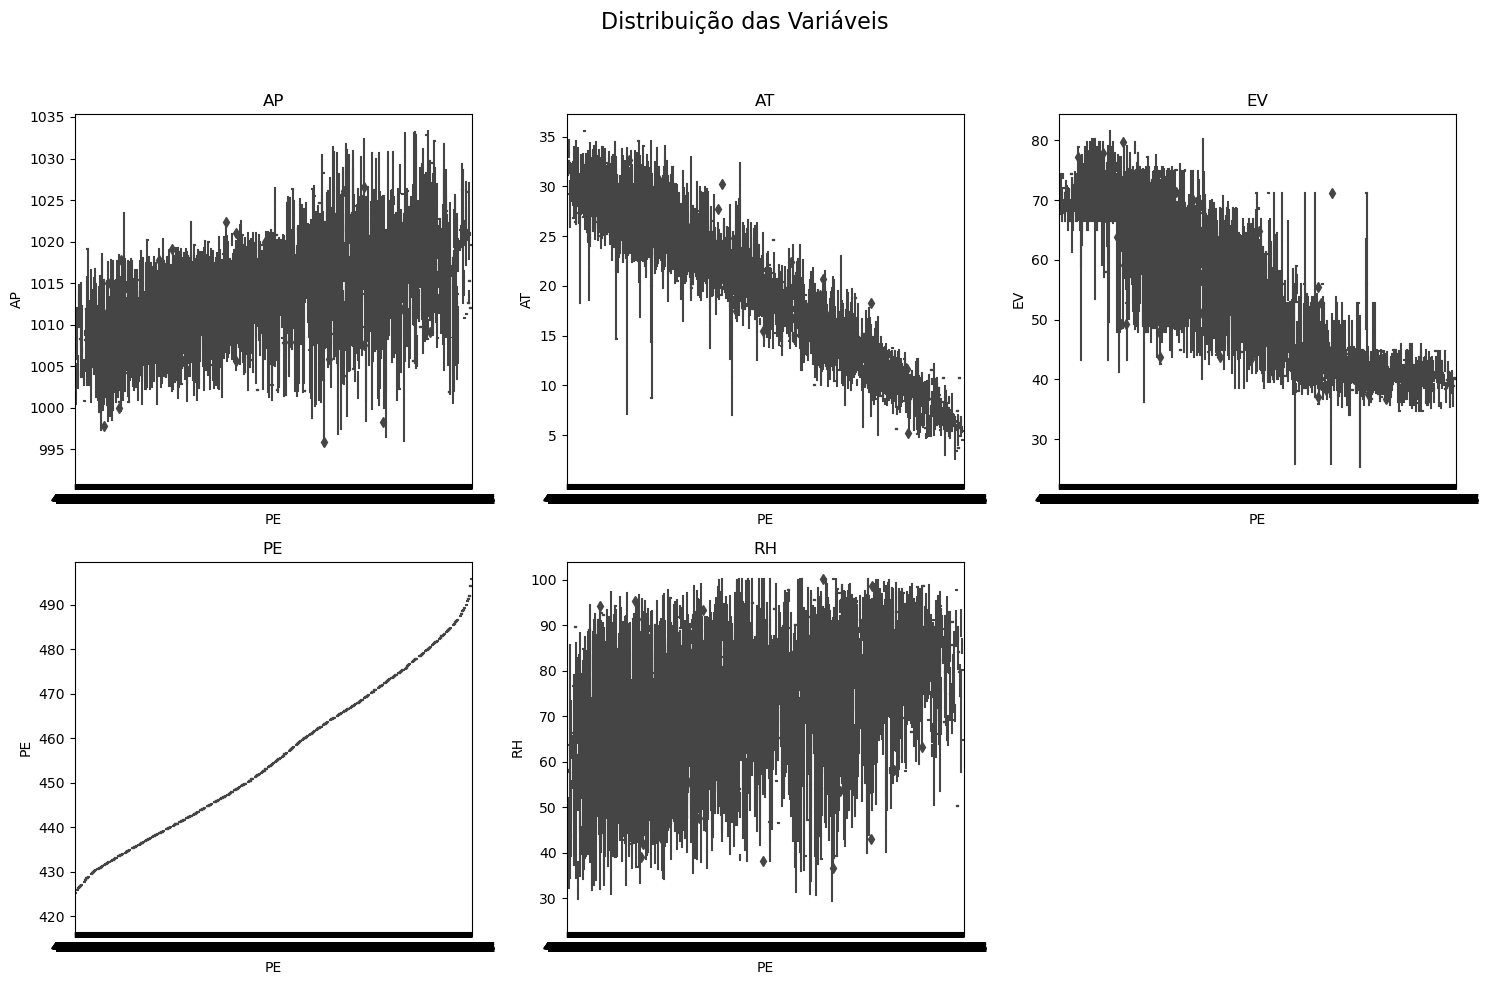

In [16]:
num_vars = len(best_corr_columns)

cols = 3
rows = math.ceil(num_vars / cols)

fig, axes = plt.subplots(nrows=rows, ncols=cols, figsize=(15, 10))
fig.suptitle("Distribuição das Variáveis", fontsize=16)

for i, col in enumerate(best_corr_columns):
    ax = axes[i // cols, i % cols]
    sns.boxplot(
        x=energy_train_data["PE"],
        y=energy_train_data[col],
        ax=ax
    )
    ax.set_title(col)

for j in range(i + 1, rows * cols):
    fig.delaxes(axes[j // cols, j % cols])

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()

# Treinando e testando o modelo

## Modelo Supervisionado

### Random Forest


In [17]:
X = energy_train_data[['AT', 'AP', 'RH', 'EV']] 
y = energy_train_data['PE']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


In [19]:
# Inicializando o regressor Random Forest
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)

# Treinando o modelo
rf_model.fit(X_train, y_train)


RandomForestRegressor(random_state=42)

In [20]:
# Predições
y_pred = rf_model.predict(X_test)


In [21]:
# Avaliação de métricas
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)


print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 12.16
R² Score: 0.96


In [24]:
!pip install xgboost

### Avaliando o modelo com XGBoost


In [30]:
xgb_model = XGBRegressor(
    n_estimators=100,
    learning_rate=0.1,
    max_depth=5,
    random_state=42
)

In [32]:
xgb_model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.1, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=100, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [33]:
y_pred = xgb_model.predict(X_test)

In [34]:
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error: {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Squared Error: 12.06
R² Score: 0.96


Ao comparar as métricas do Random Forest e do Random Forest com o XGBoost percebe-se que houve uma discreta melhora no Mean Squared Error e nenhuma mudança no R²-Score. Como o XGBoost é computacionalmente intensivo, utilizar ele apenas para uma leve melhora pode não ser uma boa alternativa, já que o valores do Random Forest apenas estão bem próximos.

O que ainda pode ser feito é o ajusto dos hiperparâmetros, o que será o nosso próximo passo.

### Tuning do XGBoost com GridSearchCV


In [37]:
param_grid = {
    'n_estimators': [100, 200, 300],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'gamma': [0, 1, 5]
}

In [39]:
xgb_model = XGBRegressor(random_state=42)

In [40]:
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='neg_mean_squared_error',
    cv=5, 
    verbose=1,
    n_jobs=-1 
)

In [41]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 729 candidates, totalling 3645 fits


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=42, ...),
             n_jobs=-1,
             param_grid={'colsample_bytree': [0.6, 0.8, 1.0],
                         'gamma': [0, 1, 5], 'learning_rate': [0.01, 0.1, 0.2],
                         'max_depth': [3, 5, 7],
                         'n_estimators': [100, 200, 300],
                         'subsample': [0.6, 0.8, 1.0]},
             scoring='neg_mean_squared_error', verbose=1)

In [42]:
print("Melhores parâmetros encontrados: ", grid_search.best_params_)

# Avaliação do melhor modelo
best_xgb_model = grid_search.best_estimator_
y_pred = best_xgb_model.predict(X_test)
mse = mean_squared_error(y_test, y_pred)
r2 = r2_score(y_test, y_pred)

print(f"Mean Squared Error otimizado: {mse:.2f}")
print(f"R² Score otimizado: {r2:.2f}")

Melhores parâmetros encontrados:  {'colsample_bytree': 1.0, 'gamma': 1, 'learning_rate': 0.1, 'max_depth': 7, 'n_estimators': 300, 'subsample': 0.8}
Mean Squared Error otimizado: 10.70
R² Score otimizado: 0.96


Ao utilizar o tuning de hiperparâmetros com o GridSearchCV percebe-se uma melhora de no mean squared error, o que siginifica que o modelo agora tem um erro menor em relação ao obtido anteriormente, equanto que o R² Score manteve-se o mesmo. Logo, podemos afirmar que o modelo teve uma melhora significativa ao utilizar o GriSearchCV